In [50]:
import mmpose
from mmpose.apis import MMPoseInferencer
import cv2 as cv
import matplotlib.pyplot as plt

In [8]:
mmpose.__version__

'1.3.1'

In [124]:
inferencer = MMPoseInferencer('human')

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-body7_pt-body7_420e-256x192-e48f03d0_20230504.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth


In [291]:
img_path = "scripts/test_img.png"
img_path2 = "scripts/test_img2.png"

In [126]:
result_generator = inferencer(img_path, show=False, draw_heatmap=True, return_vis=True)
result = next(result_generator)

C:\Users\Elton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mmpose\models\heads\coord_cls_heads\rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '


In [127]:
result["predictions"][0][0].keys()

dict_keys(['keypoints', 'keypoint_scores', 'bbox', 'bbox_score'])

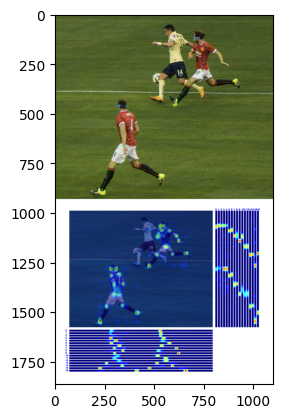

In [128]:
plt.imshow(result["visualization"][0])

In [323]:
import warnings
from typing import Optional, Tuple

from rich.progress import track

#Base from MMPoseInferencer.__call__
def modified_call(
        self,
        inputs: mmpose.apis.inferencers.mmpose_inferencer.InputsType,
        return_datasamples: bool = False,
        batch_size: int = 1,
        out_dir: Optional[str] = None,
        **kwargs,
    ) -> dict:
        """Call the inferencer.

        Args:
            inputs (InputsType): Inputs for the inferencer.
            return_datasamples (bool): Whether to return results as
                :obj:`BaseDataElement`. Defaults to False.
            batch_size (int): Batch size. Defaults to 1.
            out_dir (str, optional): directory to save visualization
                results and predictions. Will be overoden if vis_out_dir or
                pred_out_dir are given. Defaults to None
            **kwargs: Key words arguments passed to :meth:`preprocess`,
                :meth:`forward`, :meth:`visualize` and :meth:`postprocess`.
                Each key in kwargs should be in the corresponding set of
                ``preprocess_kwargs``, ``forward_kwargs``,
                ``visualize_kwargs`` and ``postprocess_kwargs``.

        Returns:
            dict: Inference and visualization results.
        """
        if out_dir is not None:
            if 'vis_out_dir' not in kwargs:
                kwargs['vis_out_dir'] = f'{out_dir}/visualizations'
            if 'pred_out_dir' not in kwargs:
                kwargs['pred_out_dir'] = f'{out_dir}/predictions'
        
        kwargs = {
            key: value
            for key, value in kwargs.items()
            if key in set.union(self.inferencer.preprocess_kwargs,
                                self.inferencer.forward_kwargs,
                                self.inferencer.visualize_kwargs,
                                self.inferencer.postprocess_kwargs)
        }
        (
            preprocess_kwargs,
            forward_kwargs,
            visualize_kwargs,
            postprocess_kwargs,
        ) = self._dispatch_kwargs(**kwargs)

        self.inferencer.update_model_visualizer_settings(**kwargs)

        # preprocessing
        if isinstance(inputs, str) and inputs.startswith('webcam'):
            inputs = self.inferencer._get_webcam_inputs(inputs)
            batch_size = 1
            if not visualize_kwargs.get('show', False):
                warnings.warn('The display mode is closed when using webcam '
                              'input. It will be turned on automatically.')
            visualize_kwargs['show'] = True
        else:
            inputs = self.inferencer._inputs_to_list(inputs)
        self._video_input = self.inferencer._video_input
        if self._video_input:
            self.video_info = self.inferencer.video_info

        inputs = self.preprocess(
            inputs, batch_size=batch_size, **preprocess_kwargs)

        # forward
        if 'bbox_thr' in self.inferencer.forward_kwargs:
            forward_kwargs['bbox_thr'] = preprocess_kwargs.get('bbox_thr', -1)

        preds = []

        for proc_inputs, ori_inputs in (track(inputs, description='Inference')
                                        if self.show_progress else inputs):
            preds = self.forward(proc_inputs, **forward_kwargs)

            visualization = self.visualize(ori_inputs, preds,
                                           **visualize_kwargs)
            
            results = self.postprocess(
                preds,
                visualization,
                return_datasamples=return_datasamples,
                **postprocess_kwargs)
            
            #MODIFIED START-----------------------------------
            if kwargs["draw_heatmap"] is True:
                for batch_index in range(len(preds)):
                    pred = preds[batch_index]
                
                    for person_index in range(len(pred.pred_instances)):
                        person_pred = pred.pred_instances[person_index]
                        
                        results["predictions"][batch_index][person_index]["heatmaps"] = pred._pred_heatmaps.heatmaps
            #MODIFIED END-------------------------------------
            
            yield results

        if self._video_input:
            self._finalize_video_processing(
                postprocess_kwargs.get('pred_out_dir', ''))

In [324]:
from types import MethodType

inferencer.modified_call = MethodType(modified_call, inferencer)

In [325]:
result_generator = inferencer.modified_call([img_path,img_path2], draw_heatmap=True)

In [326]:
results = []

for result in result_generator:
    results.append(result)

len(results)

C:\Users\Elton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mmpose\models\heads\coord_cls_heads\rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '


2

In [327]:
result = results[0]

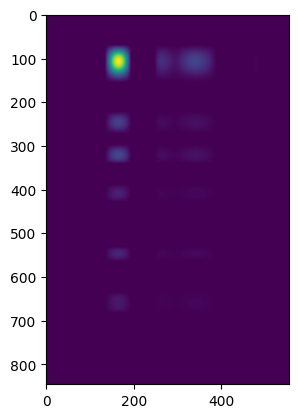

In [328]:
batch_index = 0
person_index = 0
keypoint_index = 0

plt.imshow(result["predictions"][batch_index][person_index]["heatmaps"][keypoint_index])
plt.show()